## Load and Examine Data

In [1]:
import matplotlib.pylab as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
import matplotlib.gridspec as gridspec
import os

In [2]:
import tflearn.datasets.oxflower17 as oxflower17
X, Y = oxflower17.load_data(one_hot=True, resize_pics=(64,64))

In [4]:
Y[:5]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.]])

In [3]:
print X.shape
print Y.shape

(1360, 64, 64, 3)
(1360, 17)


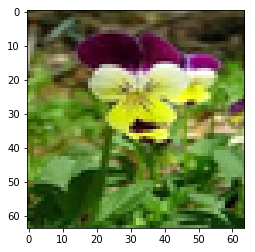

In [4]:
plt.imshow(X[30])

## GAN

In [3]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(64, 64, 3))

    return fig



In [4]:
mb_size = 128
X = X.reshape([-1, 12288])
def xavier_init(size):
    return tf.random_normal(shape=size, stddev=(1. / tf.sqrt(size[0] / 2.)))

def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob


def discriminator(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

# Discriminator Net
X_ph = tf.placeholder(tf.float32, shape=[None, 12288], name='X')
#X_tf = tf.convert_to_tensor(X, tf.float32)
#tf.reshape(X_tf, [-1, 2352])
#X_mb = tf.train.batch([X_ph], mb_size, enqueue_many = True)

D_W1 = tf.Variable(xavier_init([12288, 512]), name='D_W1')
D_b1 = tf.Variable(tf.zeros(shape=[512]), name='D_b1')

D_W2 = tf.Variable(xavier_init([512, 1]), name='D_W2')
D_b2 = tf.Variable(tf.zeros(shape=[1]), name='D_b2')

theta_D = [D_W1, D_W2, D_b1, D_b2]

# Generator Net
Z_ph = tf.placeholder(tf.float32, shape=[None, 100], name='Z')

G_W1 = tf.Variable(xavier_init([100, 1024]), name='G_W1')
G_b1 = tf.Variable(tf.zeros(shape=[1024]), name='G_b1')

G_W2 = tf.Variable(xavier_init([1024, 12288]), name='G_W2')
G_b2 = tf.Variable(tf.zeros(shape=[12288]), name='G_b2')

theta_G = [G_W1, G_W2, G_b1, G_b2]

G_sample = generator(Z_ph)
D_real, D_logit_real = discriminator(X_ph)
D_fake, D_logit_fake = discriminator(G_sample)

D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
G_loss = -tf.reduce_mean(tf.log(D_fake))

# Only update D(X)'s parameters, so var_list = theta_D
D_solver = tf.train.AdamOptimizer(0.0001).minimize(D_loss, var_list=theta_D)
# Only update G(X)'s parameters, so var_list = theta_G
G_solver = tf.train.AdamOptimizer(0.0002).minimize(G_loss, var_list=theta_G)

def sample_Z(m, n):
    '''Uniform prior for G(Z)'''
    return np.random.uniform(-1., 1., size=[m, n])



Iter: 0
D loss: 1.972
G_loss: 6.103
()


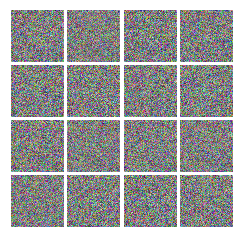

KeyboardInterrupt: 

In [6]:
Z_dim = 100
first = 0

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(tf.global_variables_initializer())

if not os.path.exists('dataset_exploration_out/'):
    os.makedirs('dataset_exploration_out/')

i = 0

D_loss_c = []
G_loss_c = []

for it in range(50000):
    if (first+mb_size <= len(X)) :
        x_input = X[first: first+mb_size, ]
    else :
        x_input = X[first: len(X), ]
        first = (first + mb_size) % len(X)
        x_input = np.append(x_input, X[0: first, ]).reshape([-1, 12288])

    
    first += mb_size

    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X_ph: x_input, Z_ph: sample_Z(mb_size, Z_dim)})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z_ph: sample_Z(mb_size, Z_dim)})

    
    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()
        D_loss_c.append(D_loss_curr)
        G_loss_c.append(G_loss_curr)
    if it % 1000 == 0:
        samples = sess.run(G_sample, feed_dict={Z_ph: sample_Z(16, Z_dim)})
        fig = plot(samples)
        plt.savefig('dataset_exploration_out/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.show(fig)

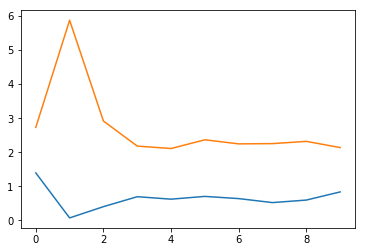

In [16]:
plt.plot(D_loss_c)
plt.plot(G_loss_c)
plt.show()

In [2]:
import tensorflow as tf

with tf.device('/cpu:0'):
    a_c = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a-cpu')
    b_c = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b-cpu')
    c_c = tf.matmul(a_c, b_c, name='c-cpu')

with tf.device('/gpu:0'):
    a_g = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a-gpu')
    b_g = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b-gpu')
    c_g = tf.matmul(a_g, b_g, name='c-gpu')

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    print (sess.run(c_c))
    print (sess.run(c_g))

print 'DONE!'

ImportError: Traceback (most recent call last):
  File "/home/tingwenbao/anaconda2/lib/python2.7/site-packages/tensorflow/python/pywrap_tensorflow.py", line 41, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/home/tingwenbao/anaconda2/lib/python2.7/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/home/tingwenbao/anaconda2/lib/python2.7/site-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
ImportError: libcudnn.so.6: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.